# Detection of Soil-Transmitted Helminths and Schistosoma Mansoni using EfficientDet

## Performance Comparison of Similar Models

<figure>
<img src="https://blog.roboflow.com/content/images/2020/06/yolov5-performance.png" style="width:700px">
</figure>

Check out the [EfficientDet Research Paper ](https://arxiv.org/pdf/1911.09070.pdf)  

## EfficientDet Structure
![image](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/efficientdet.png)

### TensorFlow Object Detection API setup

In [1]:
# Download TensorFlow model libraries
!git clone https://github.com/tensorflow/models
# Check out a certain commit to ensure that future changes in the TF OD API codebase won't affect this notebook.
!cd models && git checkout ac8d06519

Cloning into 'models'...
remote: Enumerating objects: 72952, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 72952 (delta 63), reused 107 (delta 49), pack-reused 72823
Receiving objects: 100% (72952/72952), 579.29 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (51633/51633), done.
Note: checking out 'ac8d06519'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ac8d06519 Add SpaghettiNet Feature Extractor


In [2]:
%%bash

cd /kaggle/working/models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API with fixes.
wget https://storage.googleapis.com/odml-dataset/others/setup.py
pip install -q --user .

# You can optionally test the Object Dectection API is working correctly
#python object_detection/builders/model_builder_tf2_test.py

--2022-05-16 15:47:20--  https://storage.googleapis.com/odml-dataset/others/setup.py
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 172.217.203.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1401 (1.4K) [text/x-python]
Saving to: ‘setup.py’

     0K .                                                     100% 20.4M=0s

2022-05-16 15:47:20 (20.4 MB/s) - ‘setup.py’ saved [1401/1401]

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Consider adding this directory to PATH or, if you prefer 

### Import Libraries

In [3]:
import contextlib2
import io
import IPython
import json
import numpy as np
import os
import pathlib
import pandas as pd
import sys
import tensorflow as tf
import time

from PIL import Image, ImageDraw

import glob
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import random


# TF does not release GPU memory properly in the notebook so we need to clear between tf gpu operations
#!pip install numba
from numba import cuda
import gc

In [4]:
# The notebook is supposed to run with TF 2.6.0
print(tf.__version__)
# Check that the gpu is found
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.6.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-05-16 15:48:36.142504: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-16 15:48:36.203461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:48:36.362154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:48:36.362963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### EDA

In [5]:
def get_images_and_objects(tfrecord_file, features):
    tf_dataset = tf.data.TFRecordDataset(tfrecord_file)
    imgs=[]
    bbs=[]
    labels=[]
    for data in tf_dataset:#.take(num_records_to_plot):
        example = tf.train.Example()
        example.ParseFromString(data.numpy())
        record = tf.io.parse_single_example(data, feature_description)

        image = record['image/encoded']
        object_texts = record['image/object/class/text']
        object_labels = record['image/object/class/label']
        width = record['image/width'].numpy()
        height = record['image/height'].numpy()    
        xmins = record['image/object/bbox/xmin']
        xmaxs = record['image/object/bbox/xmax']
        ymins = record['image/object/bbox/ymin']
        ymaxs = record['image/object/bbox/ymax']
        img_bbs = []
        img_labels = []

        for i in range(0,xmins.shape[0]):
            # Convert Tensors to TensorProtos and then to numpy arrays
            xmin = tf.make_ndarray(tf.make_tensor_proto(xmins.values[i]))*width
            ymin = tf.make_ndarray(tf.make_tensor_proto(ymins.values[i]))*height
            xmax = tf.make_ndarray(tf.make_tensor_proto(xmaxs.values[i]))*width
            ymax = tf.make_ndarray(tf.make_tensor_proto(ymaxs.values[i]))*height
            
            label = tf.make_ndarray(tf.make_tensor_proto(object_labels.values[i]))
            img_labels.append(label)
            
            rect = (xmin, ymin, xmax, ymax)
            img_bbs.append(rect)

        # Convert image from raw bytes to numpy array
        image_decoded = tf.image.decode_image(image)
        image_decoded_np = image_decoded.numpy()

        imgs.append(image_decoded_np)
        bbs.append(img_bbs)
        labels.append(img_labels)
        
    return imgs, bbs, labels

In [6]:
# Plot some of the training images
import random
%matplotlib inline

def object_label(object_id):
    return {
        0: '???',
        1: 'ASC.',
        2: 'TRI.',
        3: 'HKW.',
        4: 'SCH.',
    }.get(object_id, 0)

def object_color(object_id):
    return {
        0: 'black',
        1: 'red',
        2: 'blue',
        3: 'yellow',
        4: 'green',
    }.get(object_id, 0)

def plot_images(images, bounding_boxes, labels, rows=3, columns=3, sizex=40, sizey=40):
    fig, ax = plt.subplots(figsize=(sizex, sizey))

    for i in range(1, columns*rows +1):
        image_no = random.randint(0,len(images)-1)
        image = images[image_no]
        fig.add_subplot(rows, columns, i)
        for index, bbs in enumerate(bounding_boxes[image_no]):
            object_id = int(labels[image_no][index])
            #bbs = (xmin, ymin, xmax, ymax)
            #rect = ((xmin, ymin), (xmax - xmin), (ymax - ymin))
            rect = patches.Rectangle((bbs[0],bbs[1]),(bbs[2]-bbs[0]),(bbs[3]-bbs[1]), linewidth=4, edgecolor=object_color(object_id), facecolor='none')
            plt.gca().add_patch(rect)
            plt.gca().annotate(object_label(object_id), xy=rect.get_xy(), fontsize=40, color=object_color(object_id))
        plt.imshow(image)



In [7]:
filenames = glob.glob('/kaggle/input/ai4ntd-p1-5/*.record')
print(filenames)


# the feature descriptions / metadata available for every record in the TFRECORD
feature_description = {
    'image/width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'image/height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'image/encoded': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32)
}

['/kaggle/input/ai4ntd-p1-5/test.record', '/kaggle/input/ai4ntd-p1-5/train.record', '/kaggle/input/ai4ntd-p1-5/eval.record']


### Test Set summary

2022-05-16 15:48:40.312714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:48:40.313593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:48:40.314235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:48:40.314923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:48:40.315575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

There are 752 images and  1671 eggs in the test set


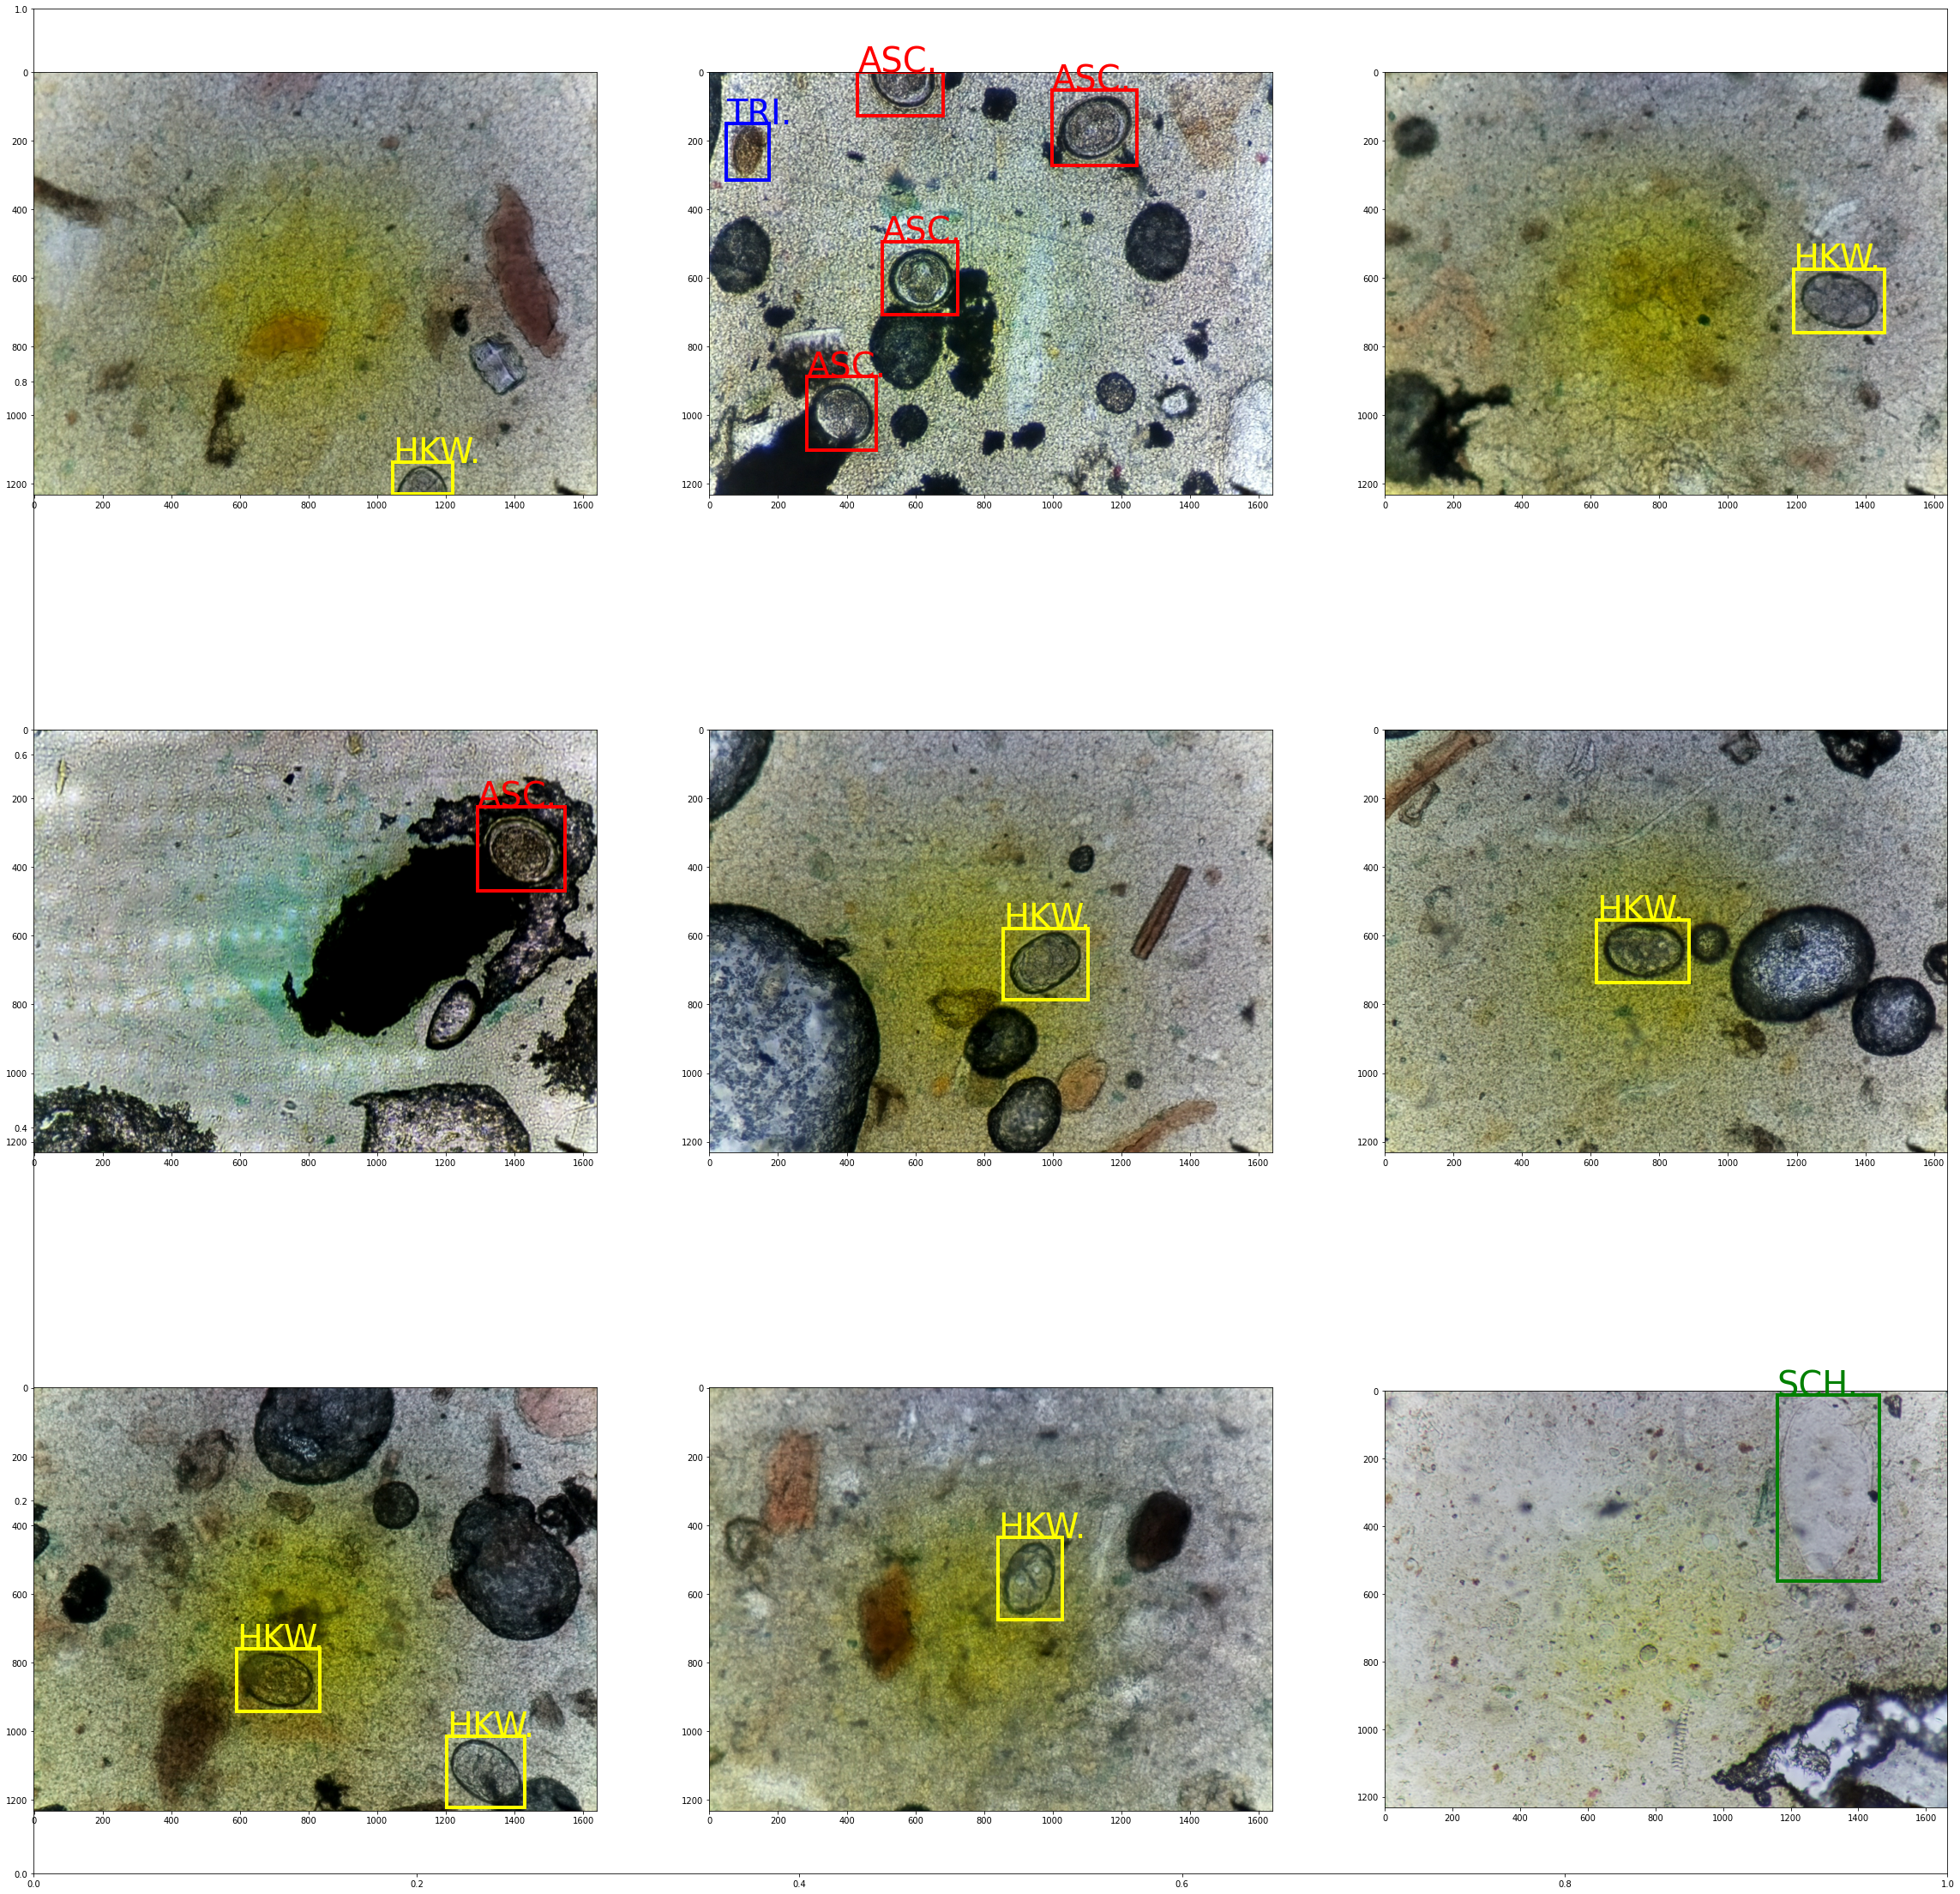

In [8]:
# Read the test record in
test_record = glob.glob('/kaggle/input/ai4ntd-p1-5/test.record')
# Extract the images, objects and labels from the record
test_images, test_objects, test_labels =  get_images_and_objects(test_record, feature_description)
eggs = sum( [ len(object) for object in test_objects])
print(f"There are {len(test_images)} images and  {eggs} eggs in the test set")
plot_images(test_images, test_objects, test_labels)

In [11]:
# This Kaggle notebook is rather limited on memory so we'll clean up before proceeding
del test_images, test_objects, test_labels
gc.collect()

# TF does not release GPU memory properly in the notebook so we need to clear between tf gpu operations
# Using tf sess does not solve this either
cuda.select_device(0)
cuda.close()

### Train an object detection model

#### Setup class label mapping

In [12]:
# Create a label map to map between label index and human-readable label name.
!mkdir /kaggle/working/dataset
label_map_str = """item {
  name: "Ascaris"
  id: 1
}
item {
  name: "Trichuris"
  id: 2
}
item {
  name: "Hookworm"
  id: 3
}
item {
  name: "Schistosoma"
  id: 4
}"""


with open('/kaggle/working/dataset/label_map.pbtxt', 'w') as f:
    f.write(label_map_str)

!more /kaggle/working/dataset/label_map.pbtxt

item {
  name: "Ascaris"
  id: 1
}
item {
  name: "Trichuris"
  id: 2
}
item {
  name: "Hookworm"
  id: 3
}
item {
  name: "Schistosoma"
  id: 4
}


In [13]:
# Download the pretrained EfficientDet-D0 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xvzf efficientdet_d0_coco17_tpu-32.tar.gz

--2022-05-16 15:49:41--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.98.128, 2607:f8b0:400c:c1a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.98.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  --.-KB/s    in 0.1s    

2022-05-16 15:49:41 (273 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
efficientdet_d

### Setup the pipeline.config

In [14]:
# This sets up a pipeline.config that uses the efficientdet_d0_coco17_tpu-32 pipeline.config as a template.
# The 'fine_tune_checkpoint', 'batch_size', 'label_map_path', 'train_record' and 'eval_record' can be configured in following steps.

from string import Template

config_file_template = """
# SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Initialized from an EfficientDet-D0 checkpoint.
#
# Train on GPU

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: [1.0, 2.0, 0.5]
        scales_per_octave: 3
      }
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
        }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        depth: 64
        class_prediction_bias_init: -4.6
        conv_hyperparams {
          force_use_bias: true
          activation: SWISH
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            random_normal_initializer {
              stddev: 0.01
              mean: 0.0
            }
          }
          batch_norm {
            scale: true
            decay: 0.99
            epsilon: 0.001
          }
        }
        num_layers_before_predictor: 3
        kernel_size: 3
        use_depthwise: true
      }
    }
    feature_extractor {
      type: 'ssd_efficientnet-b0_bifpn_keras'
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
      conv_hyperparams {
        force_use_bias: true
        activation: SWISH
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          scale: true,
          decay: 0.99,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid_focal {
          alpha: 0.25
          gamma: 1.5
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    normalize_loc_loss_by_codesize: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.5
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  fine_tune_checkpoint: $fine_tune_checkpoint
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint_type: "detection"
  batch_size: $batch_size
  sync_replicas: false
  startup_delay_steps: 0
  replicas_to_aggregate: 1
  use_bfloat16: false
  num_steps: $training_steps
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_scale_crop_and_pad_to_square {
      output_size: 512
      scale_min: 0.5
      scale_max: 2.0
    }
  }
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        cosine_decay_learning_rate {
          learning_rate_base: $learning_rate_base
          total_steps: $training_steps
          warmup_learning_rate: $warmup_learning_rate
          warmup_steps: $warmup_steps
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}

train_input_reader: {
  label_map_path: $label_map_path
  tf_record_input_reader {
    input_path: $train_record
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 1;
}

eval_input_reader: {
  label_map_path: $label_map_path
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: $eval_record
  }
}
"""

In [15]:
# Define the parameters to be updated in the training pipeline
TRAIN_RECORD = '"/kaggle/input/ai4ntd-p1-5/train.record"'
EVAL_RECORD = '"/kaggle/input/ai4ntd-p1-5/eval.record"'
LABEL_MAP_PATH = '"/kaggle/working/dataset/label_map.pbtxt"'
FINE_TUNE_CHECKPOINT = '"/kaggle/working/efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0"' # we start with the pretrained model

# Learning rate and batch size will need to be tuned. 
# Batch size determines the number of images used per batch before the model parameters are tuned/updated
# We use a batch size of 1 here due to GPU memory limitations of the free kaggle environment.
# The default batch size for 'efficientdet_d0_coco17_tpu-32' is 128.
BATCH_SIZE = 1 
# Depending on the batch size the total number of training steps and the learning rate will need to be adjusted.
# A small batch size may generally required a lower learning rate and take longer for convergence.
# A larger batch size may generally allow for a larger learning rate and converge faster.
# By using a warm up step parameter the learning rate can differ for the specified number of steps.
# i.e. The learning rate will increase linearly from WARMUP_LEARNING_RATE to LEARNING_RATE_BASE over WARMUP_STEPS
# This can help prevent early over-fitting from clustered data, particularly if the batch_size is 1.
TRAINING_STEPS = 100 # the number of steps we train for, default = 400000
LEARNING_RATE_BASE = 5e-3
WARMUP_STEPS = 100 # # the number of warmup setups with the WARMUP_LEARNING_RATE, default = 2000
WARMUP_LEARNING_RATE = 5e-4

In [16]:
# Update the pipeline.config with the specified parameters
pipeline = Template(config_file_template).substitute(
    fine_tune_checkpoint=FINE_TUNE_CHECKPOINT,
    label_map_path=LABEL_MAP_PATH,
    train_record=TRAIN_RECORD,
    eval_record=EVAL_RECORD,
    training_steps=TRAINING_STEPS,
    warmup_steps=WARMUP_STEPS,
    batch_size=BATCH_SIZE,
    learning_rate_base = LEARNING_RATE_BASE,
    warmup_learning_rate = WARMUP_LEARNING_RATE)

PIPELINE_CONFIG_PATH = '/kaggle/working/dataset/pipeline.config'
with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

### Setup Tensorboard to monitor training progress

In [17]:
# Specify and setup the directory for the new model data 
MODEL_DIR='/kaggle/working/sthsch_efficientdet_d0'
!mkdir {MODEL_DIR}

### Model training

In [18]:
!python /kaggle/working/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr {MODEL_DIR}/train.log

2022-05-16 15:49:59.774616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:49:59.784892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:49:59.785843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:49:59.787192: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Model Evaluation

In [19]:
# Load the exported model and evaluate
!python /kaggle/working/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --checkpoint_dir={MODEL_DIR} \
    --eval_timeout=0 \
    --alsologtostderr # &> {MODEL_DIR}/eval.log 

2022-05-16 15:53:22.704793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:53:22.767376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:53:22.768300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
W0516 15:53:22.773590 140141220165440 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
I0516 15:53:22.773863 140141220165440 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
I0516 15:53:22.773982 140141220165440 config_util.py:552] Maybe overwriting use_bfloat16: False
I0516 15:53:22.7

In [20]:
# View the training and evaluation progress on the tensorboard. Both training and eval
# will have finished now but it is still good to see the progress.
# In this notebook we can't run the training, evaluation and tenosorboard in parallel easily
# If you run this offline you should move these steps to separate kernels and extend the 
# --eval_timeout to something greater than the training time for the batch size e.g. 3600 seconds

#NOTE: Tensorboard has been disabled in notebooks by Kaggle, uncomment following lines to use otherwise
#from tensorboard import notebook
#%load_ext tensorboard
#%tensorboard --logdir {MODEL_DIR}

### Model Inference

In [21]:
# Export the model
!python /kaggle/working/models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_dir={MODEL_DIR} \
    --output_directory={MODEL_DIR}/output

2022-05-16 15:58:46.465595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:58:46.475709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:58:46.476524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 15:58:46.485486: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Model Evaluation

In [22]:
# Download a library that we will use to generate the confusion matrix
# Here we use a script by Santiago Valdarrama https://github.com/svpino/tf_object_detection_cm
!wget https://raw.githubusercontent.com/svpino/tf_object_detection_cm/master/confusion_matrix_tf2.py

# Read in the python script
with open('confusion_matrix_tf2.py', 'r') as file :
    cm_script_tf2 = file.read()

# We need to make a correction to the script with the IoU calculation
# Our bounding boxes are recorded as floats, normalised between 0 to 1, so the '+1' correction introduces an error
# If we were to load images and maintain bounding boxes with pixel reference the '+1' term would be necessary
cm_script_tf2 = cm_script_tf2.replace('intersection = max(0, xb - xa + 1) * max(0, yb - ya + 1)', 'intersection = max(0, xb - xa) * max(0, yb - ya)')
cm_script_tf2 = cm_script_tf2.replace('boxAArea = (g_xmax - g_xmin + 1) * (g_ymax - g_ymin + 1)', 'boxAArea = (g_xmax - g_xmin) * (g_ymax - g_ymin)')
cm_script_tf2 = cm_script_tf2.replace('boxBArea = (d_xmax - d_xmin + 1) * (d_ymax - d_ymin + 1)', 'boxBArea = (d_xmax - d_xmin) * (d_ymax - d_ymin)')    

# Write the file out again
with open('confusion_matrix_tf2.py', 'w') as file:
    file.write(cm_script_tf2)

--2022-05-16 16:00:47--  https://raw.githubusercontent.com/svpino/tf_object_detection_cm/master/confusion_matrix_tf2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13207 (13K) [text/plain]
Saving to: ‘confusion_matrix_tf2.py’

confusion_matrix_tf 100%[===================>]  12.90K  --.-KB/s    in 0s      

2022-05-16 16:00:48 (35.7 MB/s) - ‘confusion_matrix_tf2.py’ saved [13207/13207]



In [23]:
!mkdir -p {MODEL_DIR}/output/confusion_matrix/images/
!python /kaggle/working/confusion_matrix_tf2.py \
  --input_tfrecord_path /kaggle/input/ai4ntd-p1-5/test.record \
  --output_path {MODEL_DIR}/output/confusion_matrix/cm_output.csv \
  --inference_graph {MODEL_DIR}/output/saved_model \
  --class_labels {LABEL_MAP_PATH} #\
  #--draw_option True \
  #--draw_save_path {MODEL_DIR}/output/confusion_matrix/images/

2022-05-16 16:00:54.272049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 16:00:54.281897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 16:00:54.282985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/kaggle/input/ai4ntd-p1-5/test.record
Loading model...
2022-05-16 16:00:55.888905: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other ope

### Repeat evaluation now with the models trained offline

In [24]:
# First we generate a tfrecord containing the detections from the trained models
!mkdir -p '/kaggle/working/rfcn_resnet101_sthsch_1/'
!mkdir -p '/kaggle/working/rfcn_resnet101_sthsch_2/'
!mkdir -p '/kaggle/working/faster_rcnn_resnet50_sthsch_1/'
!mkdir -p '/kaggle/working/faster_rcnn_resnet101_sthsch_2/'
!mkdir -p '/kaggle/working/faster_rcnn_resnet101_sthsch_3/'

!python /kaggle/working/models/research/object_detection/inference/infer_detections.py \
    --input_tfrecord_paths='/kaggle/input/ai4ntd-p1-5/test.record' \
    --output_tfrecord_path='/kaggle/working/rfcn_resnet101_sthsch_1/detections.tfrecord' \
    --inference_graph='/kaggle/input/ai4ntd-p1-5/rfcn_resnet101_sthsch_1/frozen_inference_graph.pb'

!python /kaggle/working/models/research/object_detection/inference/infer_detections.py \
    --input_tfrecord_paths='/kaggle/input/ai4ntd-p1-5/test.record' \
    --output_tfrecord_path='/kaggle/working/rfcn_resnet101_sthsch_2/detections.tfrecord' \
    --inference_graph='/kaggle/input/ai4ntd-p1-5/rfcn_resnet101_sthsch_2/frozen_inference_graph.pb'

!python /kaggle/working/models/research/object_detection/inference/infer_detections.py \
    --input_tfrecord_paths='/kaggle/input/ai4ntd-p1-5/test.record' \
    --output_tfrecord_path='/kaggle/working/faster_rcnn_resnet50_sthsch_1/detections.tfrecord' \
    --inference_graph='/kaggle/input/ai4ntd-p1-5/faster_rcnn_resnet50_sthsch_1/frozen_inference_graph.pb'

!python /kaggle/working/models/research/object_detection/inference/infer_detections.py \
    --input_tfrecord_paths='/kaggle/input/ai4ntd-p1-5/test.record' \
    --output_tfrecord_path='/kaggle/working/faster_rcnn_resnet101_sthsch_2/detections.tfrecord' \
    --inference_graph='/kaggle/input/ai4ntd-p1-5/faster_rcnn_resnet101_sthsch_2/frozen_inference_graph.pb'

!python /kaggle/working/models/research/object_detection/inference/infer_detections.py \
    --input_tfrecord_paths='/kaggle/input/ai4ntd-p1-5/test.record' \
    --output_tfrecord_path='/kaggle/working/faster_rcnn_resnet101_sthsch_3/detections.tfrecord' \
    --inference_graph='/kaggle/input/ai4ntd-p1-5/faster_rcnn_resnet101_sthsch_3/frozen_inference_graph.pb'


2022-05-16 16:03:00.546702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 16:03:00.570424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 16:03:00.571240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 16:03:00.573738: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [25]:
# Because our models were generated with TF1 they don't load properly with TF2 CM script,
# instead we download and update the TF1 confusion matrix script
# Here we use a script by Santiago Valdarrama https://github.com/svpino/tf_object_detection_cm

%cd /kaggle/working/
# Download a library that we will use to generate the confusion matrix, note this one is for TF1
!wget https://raw.githubusercontent.com/svpino/tf_object_detection_cm/master/confusion_matrix.py

# Read in the python script
with open('confusion_matrix.py', 'r') as file :
    cm_script = file.read()
    
# Because we are actually using TF2 we need to update the script so that we ensure we use tf1 compatibility
cm_script = cm_script.replace('import tensorflow as tf', 'import tensorflow.compat.v1 as tf')

# We again need to make the correction to the script in the IoU calculation
# Our bounding boxes are recorded as floats, normalised between 0 to 1, so the '+1' for pixel correction introduces an error
# If we were to load images and maintain bounding boxes with pixel references the '+1' term would be necessary
cm_script = cm_script.replace('intersection = max(0, xb - xa + 1) * max(0, yb - ya + 1)', 'intersection = max(0, xb - xa) * max(0, yb - ya)')
cm_script = cm_script.replace('boxAArea = (g_xmax - g_xmin + 1) * (g_ymax - g_ymin + 1)', 'boxAArea = (g_xmax - g_xmin) * (g_ymax - g_ymin)')
cm_script = cm_script.replace('boxBArea = (d_xmax - d_xmin + 1) * (d_ymax - d_ymin + 1)', 'boxBArea = (d_xmax - d_xmin) * (d_ymax - d_ymin)')    
    
# Write the file out again
with open('confusion_matrix_tf1.py', 'w') as file:
    file.write(cm_script)

/kaggle/working
--2022-05-16 16:09:11--  https://raw.githubusercontent.com/svpino/tf_object_detection_cm/master/confusion_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5994 (5.9K) [text/plain]
Saving to: ‘confusion_matrix.py’

confusion_matrix.py 100%[===================>]   5.85K  --.-KB/s    in 0s      

2022-05-16 16:09:12 (42.9 MB/s) - ‘confusion_matrix.py’ saved [5994/5994]



In [26]:
!mkdir -p '/kaggle/working/confusion_matrix/'

!python /kaggle/working/confusion_matrix_tf1.py \
--detections_record '/kaggle/working/rfcn_resnet101_sthsch_1/detections.tfrecord' \
--label_map '/kaggle/input/ai4ntd-p1-5/egg_label_map.pbtxt'\
--output_path '/kaggle/working/confusion_matrix/cm_output_rfcn_resnet101_sthsch_1.csv'

!python /kaggle/working/confusion_matrix_tf1.py \
--detections_record '/kaggle/working/rfcn_resnet101_sthsch_2/detections.tfrecord' \
--label_map '/kaggle/input/ai4ntd-p1-5/egg_label_map.pbtxt'\
--output_path '/kaggle/working/confusion_matrix/cm_output_rfcn_resnet101_sthsch_2.csv'

!python /kaggle/working/confusion_matrix_tf1.py \
--detections_record '/kaggle/working/faster_rcnn_resnet50_sthsch_1/detections.tfrecord' \
--label_map '/kaggle/input/ai4ntd-p1-5/egg_label_map.pbtxt'\
--output_path '/kaggle/working/confusion_matrix/cm_output_faster_rcnn_resnet50_sthsch_1.csv'

!python /kaggle/working/confusion_matrix_tf1.py \
--detections_record '/kaggle/working/faster_rcnn_resnet101_sthsch_2/detections.tfrecord' \
--label_map '/kaggle/input/ai4ntd-p1-5/egg_label_map.pbtxt'\
--output_path '/kaggle/working/confusion_matrix/cm_output_faster_rcnn_resnet101_sthsch_2.csv'

!python /kaggle/working/confusion_matrix_tf1.py \
--detections_record '/kaggle/working/faster_rcnn_resnet101_sthsch_3/detections.tfrecord' \
--label_map '/kaggle/input/ai4ntd-p1-5/egg_label_map.pbtxt'\
--output_path '/kaggle/working/confusion_matrix/cm_output_faster_rcnn_resnet101_sthsch_3.csv'

2022-05-16 16:09:19.278143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 16:09:19.289918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 16:09:19.290879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
W0516 16:09:19.297769 140651591505728 deprecation.py:345] From /kaggle/working/confusion_matrix_tf1.py:38: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Processed 100 images
Processed 2

/kaggle/working/confusion_matrix
                                precision    recall
rfcn_resnet101_sthsch_1          0.948978  0.963314
rfcn_resnet101_sthsch_2          0.895173  0.968951
faster_rcnn_resnet50_sthsch_1    0.940354  0.955906
faster_rcnn_resnet101_sthsch_2   0.952566  0.937767
faster_rcnn_resnet101_sthsch_3   0.961217  0.958687


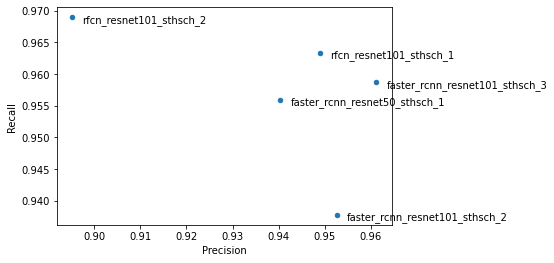

In [27]:
%cd /kaggle/working/confusion_matrix/

df1 = pd.read_csv("cm_output_rfcn_resnet101_sthsch_1.csv")
df_av = pd.DataFrame([[df1["precision_@0.5IOU"].mean(), df1["recall_@0.5IOU"].mean()]], columns=["precision", "recall"], index=['rfcn_resnet101_sthsch_1'])

df2 = pd.read_csv("cm_output_rfcn_resnet101_sthsch_2.csv")
df_av2 = pd.DataFrame([[df2["precision_@0.5IOU"].mean(), df2["recall_@0.5IOU"].mean()]], columns=["precision", "recall"], index=['rfcn_resnet101_sthsch_2'])
df_av = df_av.append(df_av2)

df3 = pd.read_csv("cm_output_faster_rcnn_resnet50_sthsch_1.csv")
df_av3 = pd.DataFrame([[df3["precision_@0.5IOU"].mean(), df3["recall_@0.5IOU"].mean()]], columns=["precision", "recall"], index=['faster_rcnn_resnet50_sthsch_1'])
df_av = df_av.append(df_av3)

df4 = pd.read_csv("cm_output_faster_rcnn_resnet101_sthsch_2.csv")
df_av4 = pd.DataFrame([[df4["precision_@0.5IOU"].mean(), df4["recall_@0.5IOU"].mean()]], columns=["precision", "recall"], index=['faster_rcnn_resnet101_sthsch_2'])
df_av = df_av.append(df_av4)

df5 = pd.read_csv("cm_output_faster_rcnn_resnet101_sthsch_3.csv")
df_av5 = pd.DataFrame([[df5["precision_@0.5IOU"].mean(), df5["recall_@0.5IOU"].mean()]], columns=["precision", "recall"], index=['faster_rcnn_resnet101_sthsch_3'])
df_av = df_av.append(df_av5)

print(df_av)

df_av.plot.scatter(x="precision", y="recall")
i=0
for x,y in zip(df_av.precision,df_av.recall):
    label = df_av.index[i]
    i+=1
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(10,-5),
                 ha='left')


plt.xlabel('Precision')
plt.ylabel('Recall')   
plt.show()